In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Import data
df = pd.read_csv("usa_housing.csv")
#df.apply(pd.to_numeric)
df.iloc[:, :-1] = df.iloc[:, :-1].apply(pd.to_numeric)
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [5]:
# Creates dataframe containing all data from United States
def get_US():
    return df.copy()

# Creates dataframe containing all data from a given state
def get_state(state_abbr):
    return df.loc[df['Address'].str.contains(state_abbr, case=True)].copy()

# Creates dataframe containing all data from a given region
def get_region(region):
    states = {
        'northeast': ['ME', 'VT', 'NH', 'MA', 'CT', 'RI', 'NY', 'PA', 'NJ', 'MD', 'DE', 'WV'],
        'midwest': ['MI', 'OH', 'IN', 'IL', 'MO', 'KS', 'IA', 'NE', 'ND', 'SD', 'MN', 'WI'],
        'south': ['VA', 'KY', 'NC', 'SC', 'TN', 'GA', 'FL', 'AL', 'MS', 'LA', 'TX', 'OK', 'AR'],
        'west': ['NM', 'AZ', 'CA', 'CO', 'UT', 'NV', 'WY', 'ID', 'OR', 'WA', 'MT', 'AK', 'HI'],
    }
    states_df = [get_state(state) for state in states[region]]
    return pd.concat(states_df, ignore_index=True)

In [6]:
## Correleation plots 
# sns.heatmap(df.corr())
# sns.PairGrid(df, hue="Price").map(plt.scatter).add_legend() 

# KNN

Data needs to be categorizable, so we partitioned it in price blocks of $150,000

In [7]:
# Uses KNN to predict housing price
def knn(knn_df, income, house_age, num_rooms, num_bedrooms, population):
  # Partition data
  price_interval = 150000
  knn_df['Price'] = knn_df['Price'].apply(lambda x: int(x//price_interval))

  X = knn_df.loc[:, [col for col in knn_df.columns[0:5]]].to_numpy(dtype=float)
  y = knn_df['Price'].to_numpy(dtype=float)

  # Normalize the data
  scaler = preprocessing.StandardScaler().fit(X)
  X_scaled = scaler.transform(X)
  all_scores = []

  # Find the best values for KFold
  for f in range(2, 21, 2):
      kf = KFold(f)
      k_max_score = []

      # Find the best values for KNN
      for k in range(1, 21, 2):
          scores = []

          # Get score for the current KNN value at the KFold
          for train_index, test_index in kf.split(X):
              X_train, X_test = X_scaled[train_index], X_scaled[test_index]
              y_train, y_test = y[train_index], y[test_index]
              knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
              scores.append(knn.score(X_test, y_test))

          k_max_score.append(max(scores))
      # Graph KFolds
      all_scores.append(k_max_score)
  kfold_graphs(all_scores)

  # Calculate prediction
  knn = KNeighborsClassifier(n_neighbors=13).fit(X_train, y_train)
  knn_result = knn.predict([[income, house_age, num_rooms, num_bedrooms, population]])[0]
  print(f"KNN: ${knn_result * price_interval} - ${(knn_result + 1) * price_interval} | Classifier output: {knn_result}")
  return knn_result


In [8]:
# Plots best K for KFold
def kfold_graphs(all_scores):
  plt.title("Max KNN score for each KFold")
  plt.plot(range(2, 21, 2), [max(ls) for ls in all_scores])
  plt.xticks(range(2, 21, 2))
  plt.xlabel("# of folds")
  plt.ylabel("Max KNN score")
  plt.show()

  # Best K for KNN plot
  plt.title("All KNN scores from the best KFolds")
  plt.plot(range(1, 20, 2), all_scores[-1], label='K = 20')
  plt.plot(range(1, 20, 2), all_scores[-2], label='K = 18')
  plt.plot(range(1, 20, 2), all_scores[-3], label='K = 16')
  plt.legend()
  plt.xticks(range(1, 20, 2))
  plt.xlabel("Value of K")
  plt.ylabel("KNN score")
  plt.show()


# Linear Regression

Perform linear regression and predicts prices using that model on test data.

In [9]:
# Uses Linear Regression to predict housing price
def linear_regression(lr_df, income, house_age, num_rooms, num_bedrooms, population):
  X = lr_df.loc[:, [col for col in lr_df.columns[0:5]]].to_numpy(dtype=float)
  y = lr_df['Price'].to_numpy(dtype=float)

  # Split data into a test and train group
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  reg = LinearRegression()
  reg.fit(X_train, y_train)

  # Prediction plot
  plt.title(f"Linear Regression Predictions r = {round(reg.score(X_test, y_test), 3)}")
  plt.scatter(y_test, reg.predict(X_test))
  plt.xlabel("Actual prices (millions)")
  plt.ylabel("Predicted prices (millions)")
  plt.show()

  # Calculate prediction
  lr_result = reg.predict([[income, house_age, num_rooms, num_bedrooms, population]])[0]
  print(f"Linear Regression: ${int(round(lr_result, -4))}")

  return lr_result


# Prediction Playground

In [10]:
# Obtain user input, i.e., income, house age, number of rooms, number of bedrooms,
# population, and region to perform prediction analysis.
def get_input():
  print('Obtain housing price predictions.')
  while True:
    try:
      income = float(input('Enter income: '))
      house_age = float(input('Enter house age: '))
      num_rooms = float(input('Enter number of rooms: '))
      num_bedrooms = float(input('Enter number of bedrooms: '))
      population = float(input('Enter population: '))
    except ValueError: 
    # if income == "" or house_age == "" or num_rooms == "" or num_bedrooms == "" or population == "":
      print('Invalid input. Try again.')
    else:
      break
  while True:
    try:
      choice = int(input('Select an Option:\n1.U.S.\n2.State\n3.Region\n'))
      if choice < 1 or choice > 3:
        raise ValueError
    except ValueError: 
      print('Invalid input. Try again.')
    else:
      if choice == 1:
        US_df = get_US()
        print('House Price Prediction for US:')
        # Get prediction models for US
        knn(US_df.copy(), income, house_age, num_rooms, num_bedrooms, population)
        linear_regression(US_df.copy(), income, house_age, num_rooms, num_bedrooms, population)
        break;
      elif choice == 2:
        state = input('Input a state abbreviation: ').upper()
        states = ['ME','VT','NH','MA','CT','RI','NY','PA','NJ','MD','DE','WV','MI',
                  'OH','IN','IL','MO','KS','IA','NE','ND','SD','MN','WI','VA','KY',
                  'NC','SC','TN','GA','FL','AL','MS','LA','TX','OK','AR','NM','AZ',
                  'CA','CO','UT','NV','WY','ID','OR','WA','MT','AK','HI']
        while state not in states:
          print('Invalid input. Try again.')
          state = input('Input a state abbreviation: ').upper()
        state_df = get_state(state)
        print('House Prediction for ' + state + ": ")
        # Get prediction models for state
        knn(state_df.copy(), income, house_age, num_rooms, num_bedrooms, population)
        linear_regression(state_df.copy(), income, house_age, num_rooms, num_bedrooms, population)
        break;
      elif choice == 3:
        region = input('Input a region (northeast, midwest, south, west):\n').lower()
        regions = ['northeast', 'midwest', 'south', 'west']
        while region not in regions:
          print('Invalid input. Try again.')
          region = input('Input a region: ').lower()
        region_df = get_region(region)
        print('House Prediction for ' + region + ": ")
        # Get prediction models for region
        knn(region_df.copy(), income, house_age, num_rooms, num_bedrooms, population)
        linear_regression(region_df.copy(), income, house_age, num_rooms, num_bedrooms, population)      
        break;


Obtain housing price predictions.
Enter income: 80000
Enter house age: 6
Enter number of rooms: 7
Enter number of bedrooms: 3
Enter population: 35000
Select an Option:
1.U.S.
2.State
3.Region
1
House Price Prediction for US:


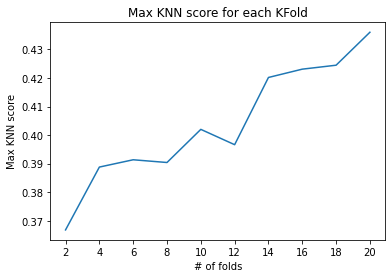

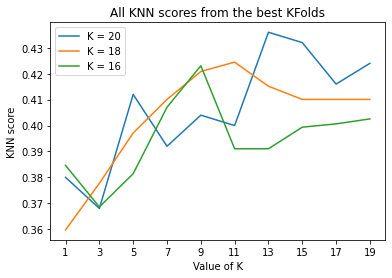

KNN: $2100000.0 - $2250000.0 | Classifier output: 14.0


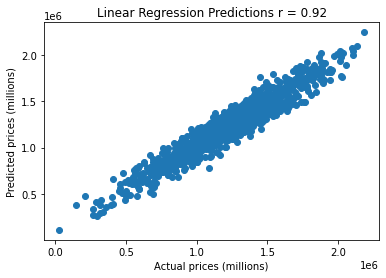

Linear Regression: $1460000


In [11]:
get_input()